In [188]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import StandardScaler
from math import ceil
from itertools import cycle
from itertools import product
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
from sklearn.model_selection import train_test_split
# used to provide a value to data that can be then used in equations, eg. Friday = 1 etc.
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import style
style.use('ggplot')
from googletrans import Translator

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle

In [31]:
#Read in .csv files into pandas dataframes
train       = pd.read_csv('sales_train.csv')
test        = pd.read_csv('test.csv').set_index('ID')
submission  = pd.read_csv('sample_submission.csv')
items       = pd.read_csv('items.csv')
item_cats   = pd.read_csv('item_categories.csv')
shops       = pd.read_csv('shops.csv')

In [32]:
#Down casts the data entries from int64 to int32 and float64 to float32
#This reduces the size of the records by almost half. (From 134mb to 61mb)
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

In [33]:
#Calls the downcasting function
train      = downcast_dtypes(train)
test       = downcast_dtypes(test)
submission = downcast_dtypes(submission)
items      = downcast_dtypes(items)
item_cats  = downcast_dtypes(item_cats)
shops      = downcast_dtypes(shops)


In [34]:
train = train.merge(items, on='item_id')

In [35]:
train = train.drop(columns = 'item_name')

In [36]:
train['date'] = pd.to_datetime(train['date'], format='%d.%m.%Y')

In [37]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,2013-01-02,0,59,22154,999.0,1.0,37
1,2013-01-23,0,24,22154,999.0,1.0,37
2,2013-01-20,0,27,22154,999.0,1.0,37
3,2013-01-02,0,25,22154,999.0,1.0,37
4,2013-01-03,0,25,22154,999.0,1.0,37
...,...,...,...,...,...,...,...
2935844,2015-10-17,33,25,8428,249.0,1.0,40
2935845,2015-10-01,33,25,7903,12198.0,1.0,15
2935846,2015-10-29,33,25,7610,2890.0,1.0,64
2935847,2015-10-22,33,25,7635,2100.0,1.0,64


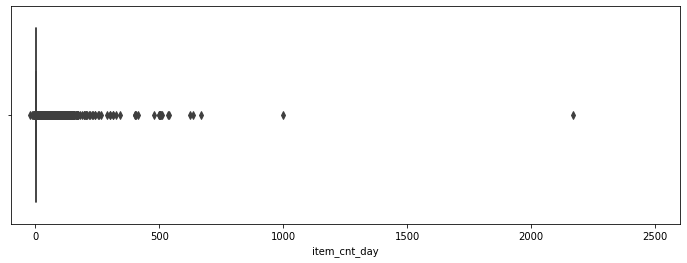

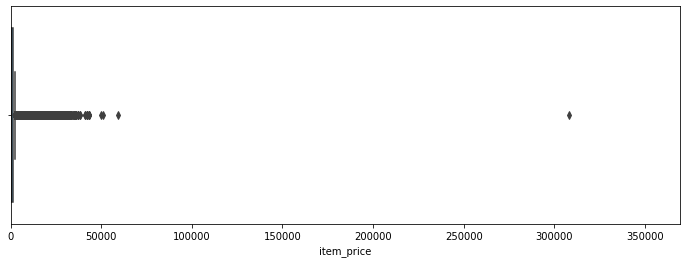

In [38]:
# Boxplot to show outliers in item_cnt_day and item_price
plt.figure(figsize=(12,4))
plt.xlim(-100, train.item_cnt_day.max()*1.2)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(12,4))
plt.xlim(train.item_price.min()*1.1, train.item_price.max()*1.2)
sns.boxplot(x=train.item_price)

In [39]:
#Removes outliers from train
train = train[train.item_price < 90000]
train = train[train.item_cnt_day < 999]

#replaces the negative price item with the median item_price of all items with the id of 2973 and in shop id 32
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()

In [40]:
train_cnt = train['item_cnt_day']
train.drop(labels=['item_cnt_day'], axis=1, inplace = True)
train.insert(6, 'item_cnt_day', train_cnt)

In [41]:
train

,date,date_block_num,shop_id,item_id,item_price,item_category_id,item_cnt_day
0,2013-01-02,0,59,22154,999.0,37,1.0
1,2013-01-23,0,24,22154,999.0,37,1.0
2,2013-01-20,0,27,22154,999.0,37,1.0
3,2013-01-02,0,25,22154,999.0,37,1.0
4,2013-01-03,0,25,22154,999.0,37,1.0
...,...,...,...,...,...,...,...
2935844,2015-10-17,33,25,8428,249.0,40,1.0
2935845,2015-10-01,33,25,7903,12198.0,15,1.0
2935846,2015-10-29,33,25,7610,2890.0,64,1.0
2935847,2015-10-22,33,25,7635,2100.0,64,1.0


In [44]:
train_grouped_month = pd.DataFrame(train.groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price'])['item_cnt_day'].sum().reset_index())

In [45]:
train_grouped_month

,date_block_num,shop_id,item_category_id,item_id,item_price,item_cnt_day
0,0,0,2,5572,1322.0,10.0
1,0,0,2,5573,560.0,1.0
2,0,0,2,5575,806.0,4.0
3,0,0,2,5576,2231.0,5.0
4,0,0,2,5609,2381.0,1.0
...,...,...,...,...,...,...
1739014,33,59,79,17717,1250.0,4.0
1739015,33,59,79,17717,1999.0,1.0
1739016,33,59,83,22087,119.0,6.0
1739017,33,59,83,22088,119.0,2.0


In [46]:
train_grouped_month.rename(columns = {'item_cnt_day':'item_cnt_month'}, inplace = True)

In [154]:
train_grouped_month

,date_block_num,shop_id,item_category_id,item_id,item_price,item_cnt_month
0,0,0,2,5572,1322.0,10.0
1,0,0,2,5573,560.0,1.0
2,0,0,2,5575,806.0,4.0
3,0,0,2,5576,2231.0,5.0
4,0,0,2,5609,2381.0,1.0
...,...,...,...,...,...,...
1739014,33,59,79,17717,1250.0,4.0
1739015,33,59,79,17717,1999.0,1.0
1739016,33,59,83,22087,119.0,6.0
1739017,33,59,83,22088,119.0,2.0


In [155]:
train_grouped_month['item_id'].value_counts()

17717    7475
7893     2009
2445     1993
4244     1941
6675     1856
         ... 
1281        1
9028        1
10052       1
4931        1
0           1
Name: item_id, Length: 21806, dtype: int64

In [157]:
num_dif_price = train_grouped_month.groupby(['shop_id', 'item_id']).size().reset_index(name='num_different_prices')

In [187]:
num_dif_price[num_dif_price['num_different_prices'] > 200]

,shop_id,item_id,num_different_prices
22120,4,17717,264
40169,6,17717,288
49086,7,17717,277
64247,12,11365,241
64251,12,11369,415
64252,12,11370,560
64255,12,11373,460
138893,22,17717,238
149852,24,17717,211
163569,25,17717,241


In [204]:
t = Translator()
items['english_name'] = items['item_name'].apply(lambda x: t.translate(x))

In [207]:
print(items['english_name'][0])

Translated(src=ru, dest=en, text=! IN THE POWER OF NAVIGATION (PLASTIC) D, pronunciation=[[]], extra_data="{'translat...")


In [208]:
items.to_csv('items_translated.csv')

In [185]:
items[items['item_id'] == 17717]

,item_name,item_id,item_category_id
17717,Прием денежных средств для 1С-Онлайн,17717,79


In [160]:
table = num_dif_price['num_different_prices'].value_counts()

In [165]:
table

1      144237
2       79161
3       50065
4       34296
5       24511
        ...  
121         1
125         1
128         1
130         1
98          1
Name: num_different_prices, Length: 121, dtype: int64

In [170]:
#43
#55
#12
one_shop_df = train_grouped_month[train_grouped_month['shop_id'] == 12]

In [171]:
one_shop_df['item_id'].value_counts()

11370    560
11373    460
11369    415
11365    241
13753    159
        ... 
16046      1
13999      1
3044       1
21471      1
2049       1
Name: item_id, Length: 7381, dtype: int64

In [172]:
#5822
#492
#11370
one_shop_one_item_df = one_shop_df[one_shop_df['item_id'] == 11370]

In [173]:
#one_shop_one_item_df = one_shop_one_item_df.set_index('date_block_num')

In [174]:
one_shop_one_item_df.head(10)

,date_block_num,shop_id,item_category_id,item_id,item_price,item_cnt_month
11416,0,12,9,11370,214.285721,7.0
11417,0,12,9,11370,285.714294,7.0
11418,0,12,9,11370,333.333344,3.0
11419,0,12,9,11370,357.142853,7.0
11420,0,12,9,11370,375.000000,12.0
11421,0,12,9,11370,464.285706,7.0
11422,0,12,9,11370,500.000000,7.0
11423,0,12,9,11370,666.666687,3.0
11424,0,12,9,11370,750.000000,2.0
11425,0,12,9,11370,1000.000000,5.0


In [175]:
one_shop_one_item_df = one_shop_one_item_df.reset_index(drop=True)

In [176]:
one_shop_one_item_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560 entries, 0 to 559
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date_block_num    560 non-null    int64  
 1   shop_id           560 non-null    int64  
 2   item_category_id  560 non-null    int64  
 3   item_id           560 non-null    int64  
 4   item_price        560 non-null    float64
 5   item_cnt_month    560 non-null    float32
dtypes: float32(1), float64(1), int64(4)
memory usage: 24.2 KB


In [113]:
# nominal intergers can not be converted to binary encoding, convert to string
one_shop_one_item_df['date_block_num']   = [('month ' + str(i)) for i in one_shop_one_item_df['date_block_num']]
one_shop_one_item_df['shop_id']          = [('shop ' + str(i)) for i in one_shop_one_item_df['shop_id']]
one_shop_one_item_df['item_category_id'] = [('item_category ' + str(i)) for i in one_shop_one_item_df['item_category_id']]
one_shop_one_item_df['item_id']          = [('item ' + str(i)) for i in one_shop_one_item_df['item_id']]

In [114]:
# break into X and Y, where X is the inputs and Y is our output
x = one_shop_one_item_df.iloc[:, :-1].values
y = one_shop_one_item_df.iloc[:,-1].values

In [115]:
ct = ColumnTransformer([('encoder', OneHotEncoder(), [0, 1, 2, 3])], remainder = 'passthrough')
#X = np.array(ct.fit_transform(X), dtype=object)
x = ct.fit_transform(x)

In [116]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y,test_size = 0.2, random_state = 0)

In [117]:
regressor = LinearRegression()
regressor.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [129]:
one_shop_test = test[test['shop_id'] == 55]

In [130]:
one_shop_test = one_shop_test[one_shop_test['item_id'] == 492]

In [132]:
one_shop_test

,shop_id,item_id
ID,,
157534,55,492


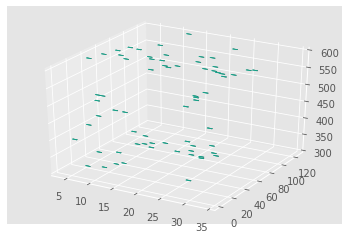

In [148]:
fig3 = plt.figure()
ax3 = fig3.add_subplot(111, projection='3d')

xpos = one_shop_one_item_df['date_block_num']
ypos = one_shop_one_item_df['item_cnt_month']
num_ele = len(xpos)
zpos = one_shop_one_item_df['item_price']

dx = np.ones(num_ele)
dy = np.ones(num_ele)
dz = np.ones(num_ele)

ax3.bar3d(xpos, ypos, zpos, dx, dy, dz, color = '#00ceaa')
plt.show()

In [177]:
fig = px.scatter_3d(one_shop_one_item_df, x='date_block_num', y='item_price', z='item_cnt_month', color='item_price')
fig.show()

In [134]:
fig = px.scatter(one_shop_one_item_df, x='date_block_num', y='item_cnt_month', opacity=0.65)
fig.show()

In [153]:
fig = px.scatter_3d(one_shop_one_item_df,  x='date_block_num', y='item_price', z='item_cnt_month', color='item_price')
fig.show()

In [83]:
fig1 = px.scatter(one_shop_one_item_df, x='date_block_num', y='item_price')
fig1.show()